# This is my 25. Video Game Sales Project

# Import Required Libraires

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost
from xgboost import XGBRegressor

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Save the model
import joblib

# Load Dataset

In [2]:
data = pd.read_csv('video games sales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


# Checking for Duplicated Rows and columns

In [4]:
print(" Number of duplicated rows:", data.duplicated().sum())

print(" Number of duplicated columns:", data.columns.duplicated().sum())

 Number of duplicated rows: 0
 Number of duplicated columns: 0


# All missing values handled

In [5]:
for col in data.columns:
    if data[col].dtype in ["int64", "float64"]:   # Numeric columns
        data[col] = data[col].fillna(data[col].median())
    else:                                         # Categorical columns
        data[col] = data[col].fillna(data[col].mode()[0])

print("All missing values handled!")
print(data.isnull().sum())

All missing values handled!
Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


# Checking for 'object' number of unique values

In [6]:
cat = data.select_dtypes(include='object')
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].nunique()}")

Name
11493
Platform
31
Genre
12
Publisher
578


# Checking for 'object' unique values

In [7]:
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].unique()}")

Name
['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ... 'Plushees'
 'Woody Woodpecker in Crazy Castle 5' 'Know How 2']
Platform
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Genre
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
Publisher
['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft' 'Atari' '505 Games' 'Capcom'
 'GT Interactive' 'Konami Digital Entertainment'
 'Sony Computer Entertainment Europe' 'Square Enix' 'LucasArts'
 'Virgin Interactive' 'Warner Bros. Interactive Entertainment'
 'Universal Interactive' 'Eidos Interactive' 'RedOctane' 'Vivendi Games'
 'Enix Corporation' 'Namco Bandai Games' 'Palcom' 'Hasbro Interactive'
 'THQ' 'Fox I

In [8]:
data['Genre'] = data['Genre'].str.strip().str.title().str.replace('-','',regex = True)
data['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'RolePlaying', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

# Clean Text

In [9]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)   # remove punctuation
    text = re.sub(r'\d+', '', text)       # remove digits
    return text

def clean_multiple_columns(data, columns):
    for col in columns:
        data[col] = data[col].astype(str).apply(clean_text)
    return data


# Clean Multiple Columns

In [10]:
data = pd.DataFrame(data)

# Columns to clean
text_columns = ['Name', 'Publisher']

# Clean them
data = clean_multiple_columns(data, text_columns)

In [11]:
cat = data.select_dtypes(include='object').columns
num = data.select_dtypes(include='float64').columns

In [12]:
for i in num:
    data[i] = data[i].astype('int64')

# Encoding

In [13]:
le = LabelEncoder()
for i in cat:
    data[i] = le.fit_transform(data[i])
    data[i] = data[i].astype('int64')

In [14]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,10227,26,2006,10,362,41,29,3,8,82
1,2,8656,11,1985,4,362,29,3,6,0,40
2,3,5173,26,2008,6,362,15,12,3,3,35
3,4,10229,26,2009,10,362,15,11,3,2,33
4,5,6757,5,1996,7,362,11,8,10,1,31


# Scale

In [15]:
sc = StandardScaler()
data[['Name']] = sc.fit_transform(data[['Name']])
data['Name'].head()

0    1.575287
1    1.062680
2   -0.073801
3    1.575939
4    0.443048
Name: Name, dtype: float64

# Checking Outliers

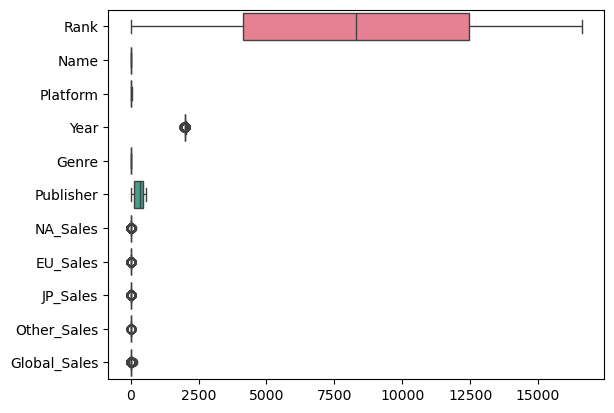

In [16]:
sns.boxplot(data = data, orient='h')
plt.show;

In [17]:
data.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

# Feature Relationships with Global Sales

<Figure size 1400x800 with 0 Axes>

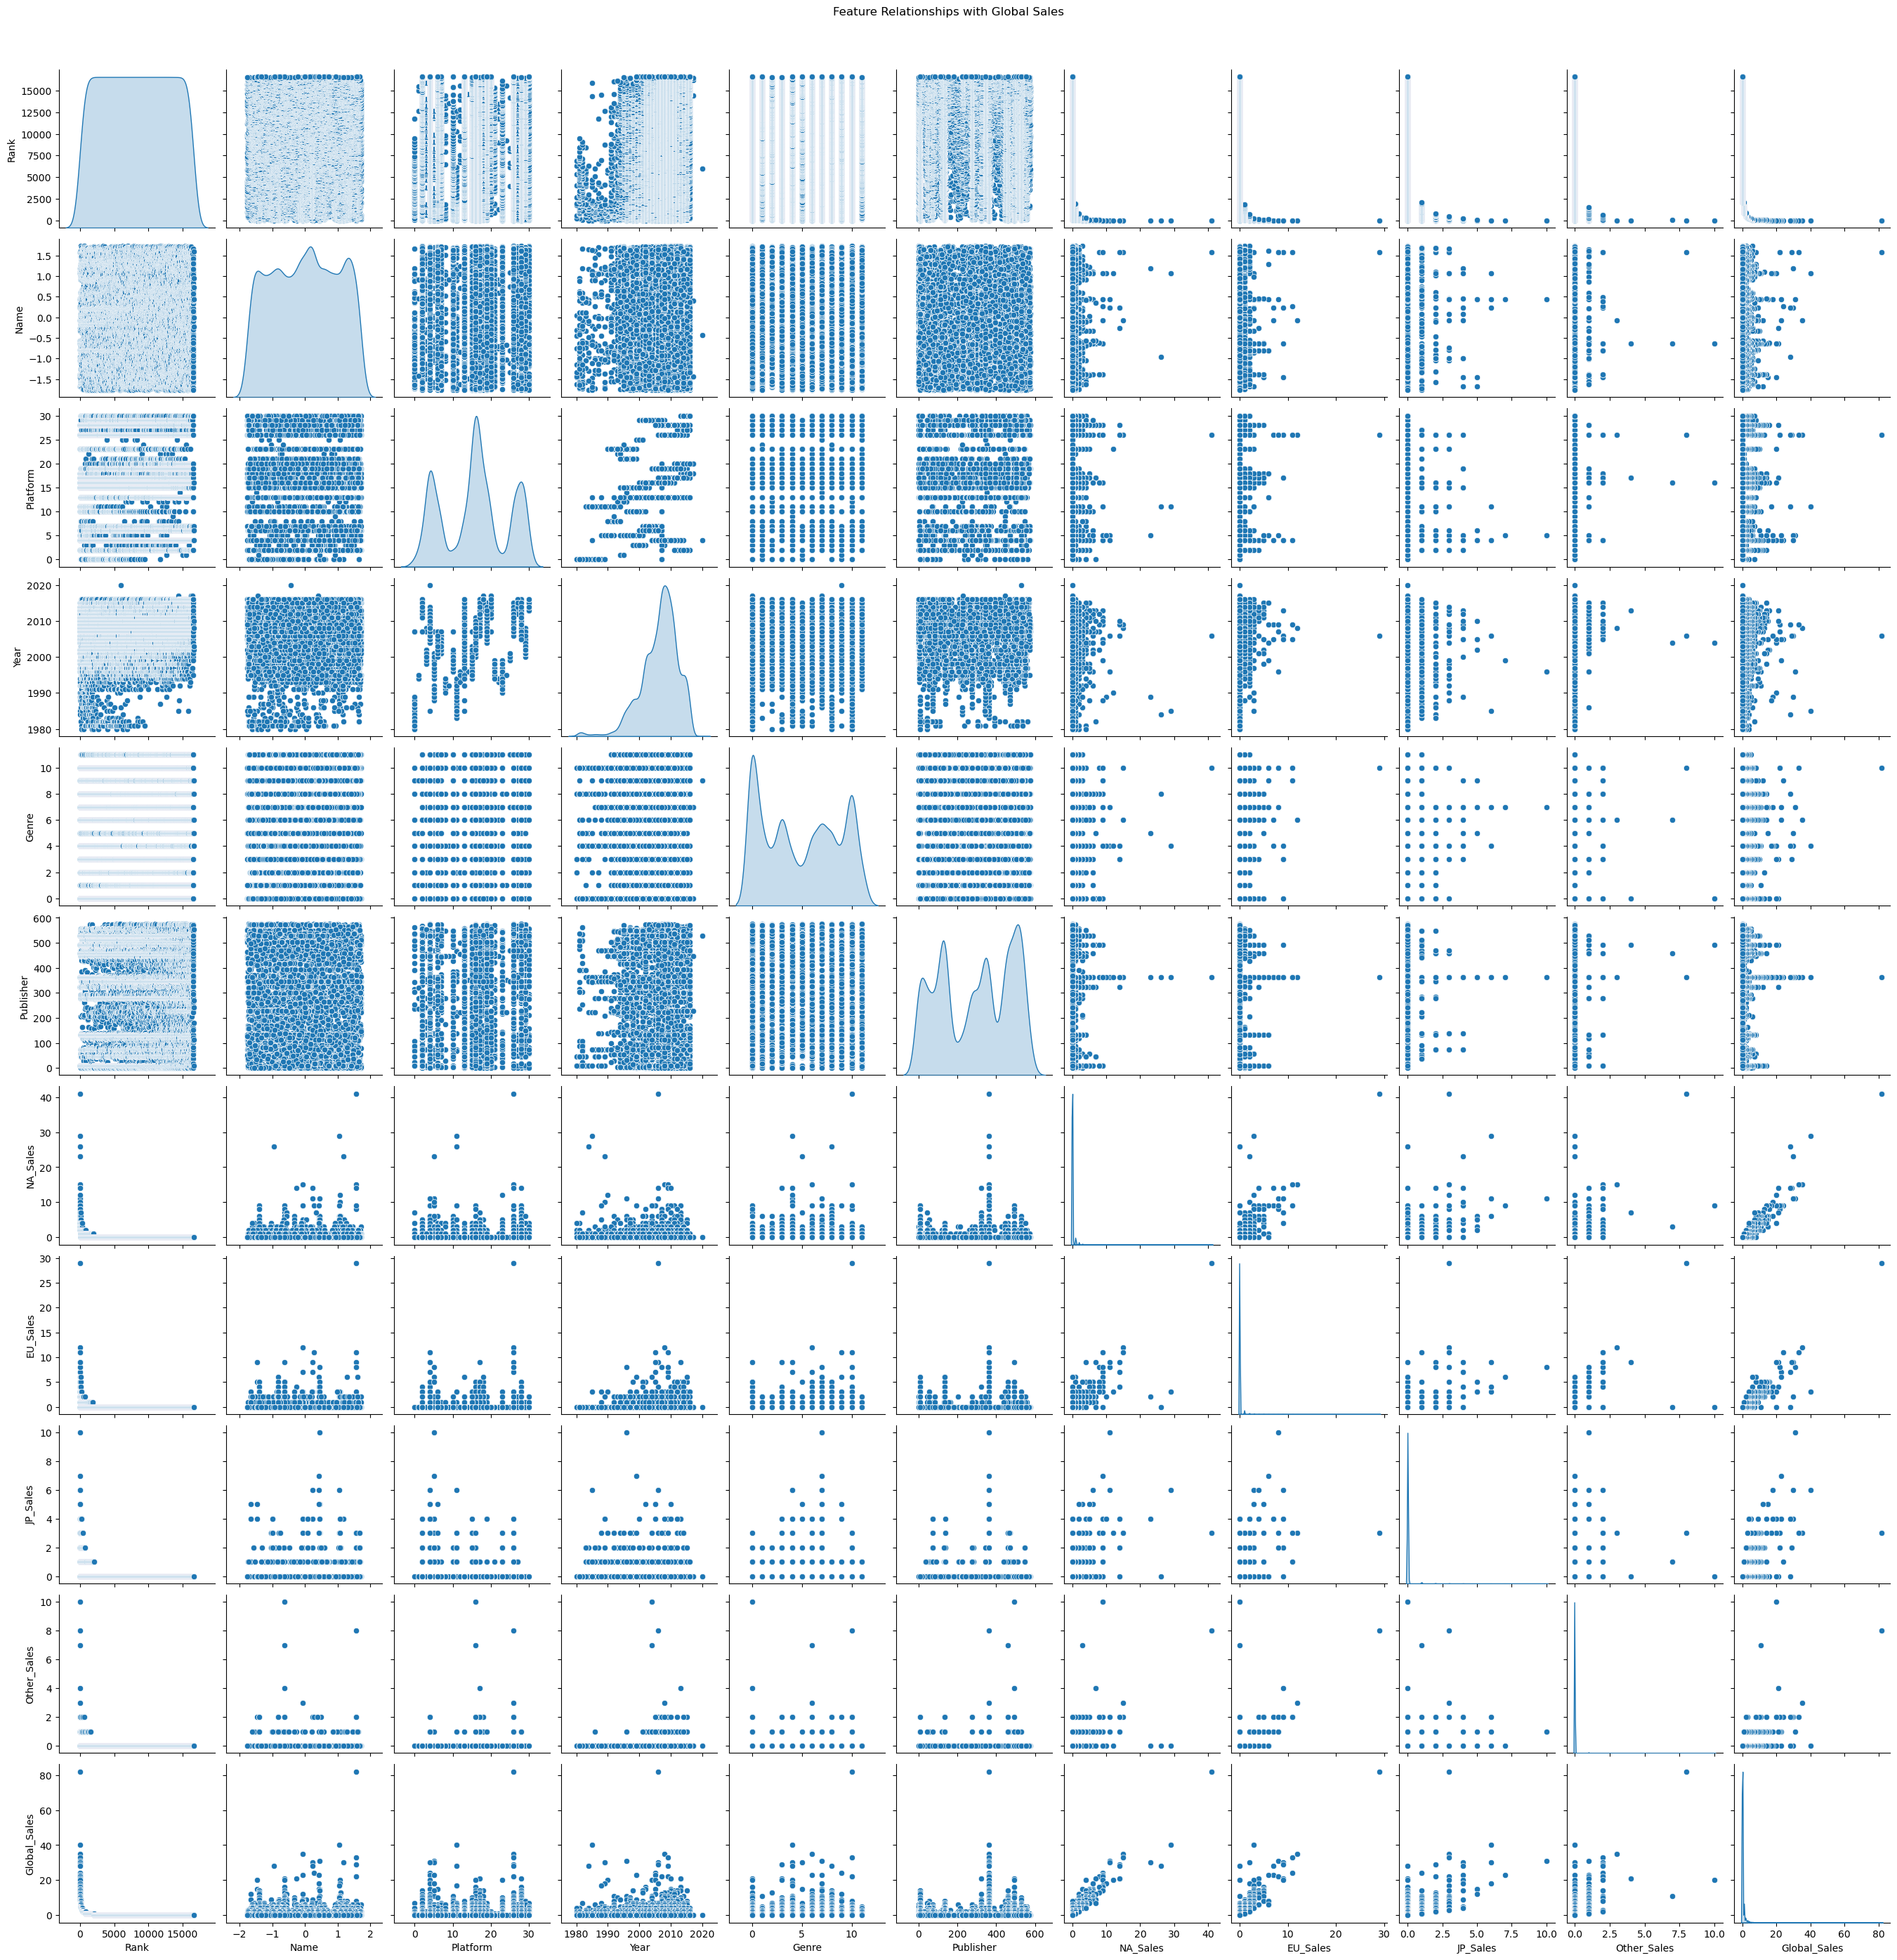

In [18]:
plt.figure(figsize=(14,8))
sns.pairplot(data[['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']], diag_kind='kde')
plt.suptitle("Feature Relationships with Global Sales", y=1.02)
plt.show();

# Correlation Heatmap

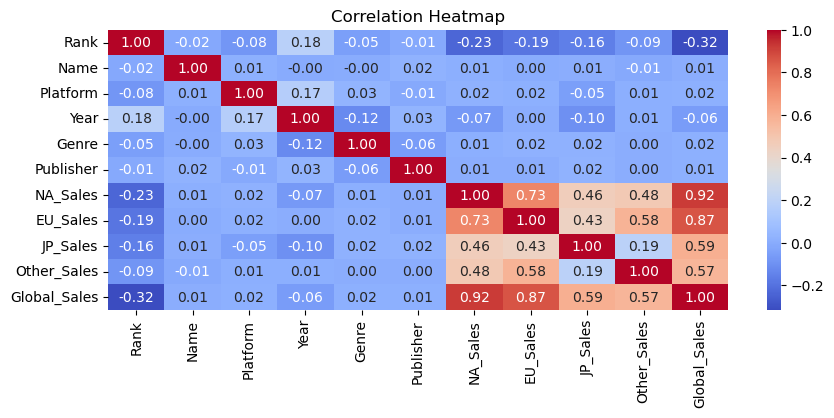

In [19]:
plt.figure(figsize=(34,8))
plt.subplot(2,3,2)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show();

# Global Sales Distribution

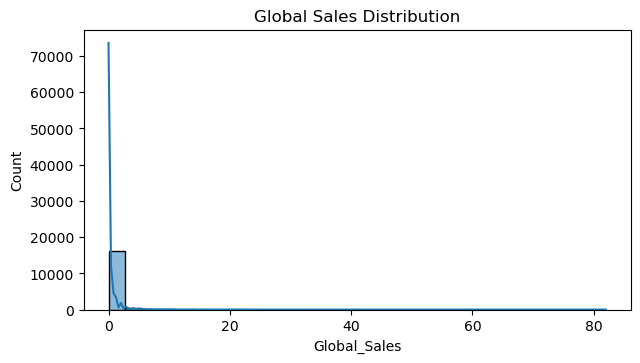

In [20]:
plt.figure(figsize=(24,8))
plt.subplot(2,3,1)
sns.histplot(data['Global_Sales'], kde=True, bins=30)
plt.title('Global Sales Distribution')
plt.show();

# Splitting for Target and Feature into Train Test Split

In [21]:
X = data.drop(['Global_Sales'],axis=1)
y = data['Global_Sales']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Preprocessing Pipeline

In [22]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Define Dictionary models

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=537),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=537),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=537),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=537),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=537)
}

# Prediction Results

In [24]:
results = []

for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "RMSE": rmse,
        'MAE': mae,
        "R2 Score": r2
    })
    
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
results_df

,Model,RMSE,MAE,R2 Score
3,Random Forest,0.029791,0.001346,0.999376
4,Gradient Boosting,0.045243,0.001567,0.998561
6,Extra Trees,0.054045,0.006985,0.997947
9,XGBoost,0.126613,0.018350,0.988731
5,AdaBoost,0.191420,0.128808,0.974243
0,Linear Regression,0.277404,0.178464,0.945906
1,Ridge Regression,0.277410,0.178468,0.945903
8,K-Nearest Neighbors,0.330935,0.095542,0.923014
7,Support Vector Regressor,0.689687,0.144308,0.665629
2,Lasso Regression,0.937322,0.393949,0.382407


# Define models & parameter grids for regressor

In [30]:
models = {
    # -------------------------------
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {
            "fit_intercept": [True, False],
            "copy_X": [True, False]
        }
    },
    # -------------------------------
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    # -------------------------------
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    # -------------------------------
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    # -------------------------------
    "Extra Trees": {
        "model": ExtraTreesRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    },
    # -------------------------------
    "MLP Regressor": {
        "model": MLPRegressor(random_state=42, max_iter=500),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    # -------------------------------
    "XGBoost": {
        "model": XGBRegressor(objective="reg:squarederror", random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}

print(f" Total Regression Models Loaded: {len(models)}")

 Total Regression Models Loaded: 9


# Run GridSearchCV for each regressor model

In [31]:
results = []
best_score = -float('inf')
best_model = None
best_name = None

for name, config in models.items(): 
    print(f"\n Running GridSearchCV for {name}...")
    
    model = config["model"]
    param_grid = config["param_grid"]
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    print(f" {name} Best CV R²: {grid.best_score_:.4f}")
    print(f"   Best Params: {grid.best_params_}")

    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

print("\n Summary Results:")
print(results_df)

print(f"\n Best Model: {best_name}")
print(f" Best CV Score (R²): {best_score:.4f}")


 Running GridSearchCV for Linear Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Linear Regression Best CV R²: 0.9626
   Best Params: {'copy_X': True, 'fit_intercept': True}

 Running GridSearchCV for Decision Tree...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
 Decision Tree Best CV R²: 0.9499
   Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

 Running GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Random Forest Best CV R²: 0.9461
   Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 Running GridSearchCV for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Gradient Boosting Best CV R²: 0.9504
   Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

 Running GridSearchCV for AdaBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
 AdaBoost Be

# Scatter Plot: Predicted vs Actual

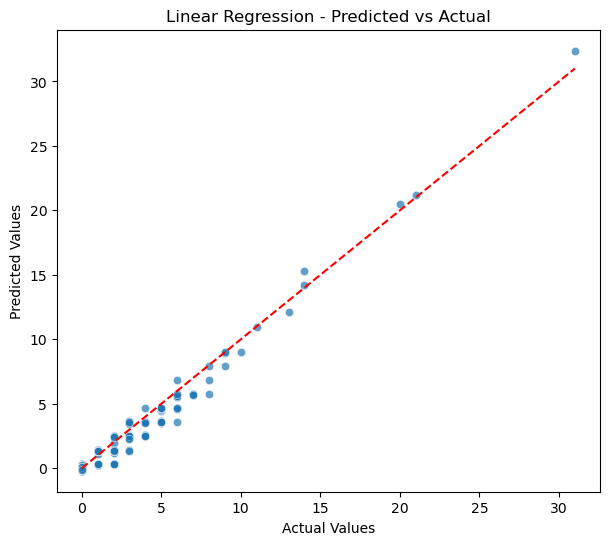

In [32]:
y_pred = best_model.predict(X_test)

# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_name} - Predicted vs Actual")
plt.show()

# Residuals Distribution

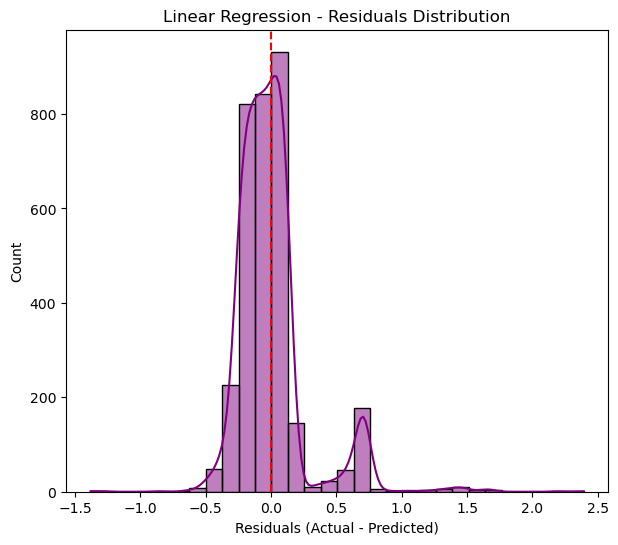

In [33]:
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.histplot(residuals, kde=True, bins=30, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title(f"{best_name} - Residuals Distribution")
plt.show()

# Feature Importance

In [34]:
if hasattr(best_model, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
    plt.title(f"{best_name} - Feature Importance")
    plt.show()
else:
    print(f" Feature importance not available for {best_name}")

 Feature importance not available for Linear Regression


# Save The Model

In [35]:
feature_columns = X.columns.to_list()
joblib.dump(feature_columns,'features 25.Video Game Sales.joblib')

['features 25.Video Game Sales.joblib']

In [36]:
joblib.dump(best_model,'best model 25.Video Game Sales.joblib')

['best model 25.Video Game Sales.joblib']

# If you have any suggestions, please DM me.
# Even a small message from you can make a big impact on my career
#### I am Arun